# Crystallinity maps of semicrystalline polymer (R-BAPB) 
## 2D X-ray scattering experiment



### TODO:
-  посмотреть среднее гало - сборное - для всех образцов + подгон по Pearson IV
-  маски по гистограммам?
-  подгон пиков в игоре Voigt, первое приближение - гаусс.
-  корреляция формы гало и кристалличности
-  подгон гало Pearson IV, но гало разное для кристаллических и не кристаллических сртуктур
-  индекс кристалличности
-  на сплавленных образцах усреднить все, а не маску.
-  различие в положениях пиков?
-  сакс? -  координаты lnx-lny


In [1]:
import h5py
import numpy as np
import scipy as scipy
from scipy import optimize
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.ticker as ticker
import time
import peakutils

%matplotlib inline

In [2]:
#Initial global parameters

file_name = "H://LP/R-BAPB/print1434.h5"
file_num = '1434'
data_inner_directory = "data/data" # path to data inside the file
map_width = 1 #default value
min_ROI_q = 570 # region of interest for q, data point indices
max_ROI_q = 730
min_ROI_chi = 0 # region of interest for angle chi, data point indices
max_ROI_chi = 720 

In [3]:
#Opening h5 file
file = h5py.File(file_name, "r") # reading mode
all_scans = file[data_inner_directory] 
map_width = int(all_scans.shape[0]**0.5) 
q_set = file["data/q"] # actual values for q and chi


chi_set = file["data/chi"]

In [ ]:
import scipy.signal
#sample profile fitting
min_ROI_q = 570 # region of interest for q, data point indices
max_ROI_q = 650


scan = all_scans[1200]
profile_sum = np.zeros(all_scans.shape[2], dtype=np.float32)
        
j_counter = 0
for j in range (min_ROI_chi,max_ROI_chi):
    profile = scan[j]           
    if (-10 not in profile[min_ROI_q-70:max_ROI_q+70]):
        profile_sum += profile
        j_counter+=1
profile_sum/=j_counter

y_wide = scipy.signal.savgol_filter(profile_sum[min_ROI_q-70:max_ROI_q+70], window_length=25, polyorder= 3, deriv=0, delta=0.1, axis=-1, mode='interp', cval=0.0)
#base = peakutils.baseline(y_wide, deg=5)
#y_wide-=base

x = q_set[min_ROI_q:max_ROI_q]
y = y_wide[70:-70]


def gaussian(x, mu, sig, A, y0):
    return y0 + A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))



popt, pcov = scipy.optimize.curve_fit(gaussian, x, y, p0=[1.3,0.05,0.5,0.1])
print(popt)

plt.figure(figsize=(10,6))
plt.plot(x,profile_sum[min_ROI_q:max_ROI_q])
plt.plot(x, y, label = "original profile - 1434 masked normalized")
plt.plot(x, gaussian(x, *popt), label=' gaussian fit')
plt.legend()

I = scipy.integrate.trapz(x = x, y = gaussian(x, *popt))
print(I)



In [ ]:
#Mapping by simply integrating in ROI_q

def gaussian(x, mu, sig, A, y0):
    return y0 + A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))



#baseline = np.load('1434profile.npy')
start_time = time.time() #time counter
simple_map_data = np.zeros((map_width,map_width), dtype=np.float32) 

for i in range(map_width**2):
        current_scan = all_scans[i]   
        profile_sum = np.zeros(all_scans.shape[2], dtype=np.float32)
        
        j_counter = 0
        for j in range (min_ROI_chi,max_ROI_chi):
            profile = current_scan[j]           
            if (-10 not in profile[min_ROI_q-70:max_ROI_q+70]):
                profile_sum += profile
                j_counter+=1
        profile_sum/=j_counter
        
        
        y_wide = scipy.signal.savgol_filter(profile_sum[min_ROI_q-70:max_ROI_q+70], window_length= 25, polyorder= 3, deriv=0, delta=0.1, axis=-1, mode='interp', cval=0.0)
        base = peakutils.baseline(y_wide, deg=5)
        y_wide-=base

        x = q_set[min_ROI_q:max_ROI_q]
        y = y_wide[70:-70]

        popt, pcov = scipy.optimize.curve_fit(gaussian, x, y, p0=[1.3,0.05,0.5,0.1], method = 'dogbox')
        I = scipy.integrate.trapz(x = x, y = gaussian(x, *popt))
        print(I)
        
        
        x = int(i%map_width)
        y = int(i//map_width)
        
        simple_map_data[y, x]=I
        print(i,"--- %s seconds ---" % (time.time() - start_time))

#saving map data

#np.save(file_num + 'simple_map_data', simple_map_data)

In [ ]:
#Summing all  scans of the experiment


scan_sum = np.zeros((all_scans.shape[1],all_scans.shape[2]), dtype = np.float32)
start_time = time.time()
for scan in all_scans:
    scan_sum+=scan
    print("--- %s seconds ---" % (time.time() - start_time))
    
scan_sum/=all_scans.shape[0] #normalizing

#saving

np.save('scan_sum' + file_num, scan_sum)

In [ ]:
#Assembling a normilized profile from different parts of a scan (because yeah I don't have mask files)

#scan_sum = np.load('scan_sum' + file_num + '.npy', )

#TODO - зашкал при i=6 - почему???
#Сшивка между срезами - чем больше N, тем меньше разница

M = all_scans.shape[2] #number of points in profile
N=3 #number of slices
halo_profile = np.zeros(M, dtype=np.float32)
for i in range(N):  
    
    min_slice = int(M*i/N)
    max_slice = int(M*(i+1)/N)
    counter = 0 
    print(i, min_slice, max_slice)
    local_sum = np.zeros(M, dtype=np.float32)
    
    for j in range(min_ROI_chi, max_ROI_chi):
        profile = scan_sum[j]
        if not any(x<=0 for x in profile[min_slice:max_slice]):
            local_sum[min_slice:max_slice]+=profile[min_slice:max_slice]        
            counter +=1
                
    print(counter)
    halo_profile[min_slice:max_slice] += (local_sum[min_slice:max_slice]/counter) 


fig = plt.figure(figsize=(15,10))
plt.plot(q_set,halo_profile, label = 'halo profile')


#Setting scale 
ax = fig.add_subplot(2, 1, 1)
ax.loglog(q_set,halo_profile, label = 'loglog halo profile')

#ax.set_xscale('log')
#ax.set_yscale('log')
plt.legend()

#saving
np.save('halo_profile' + file_num, scan_sum)
np.savetxt('halo_profile' + file_num + '.txt', halo_profile)
np.savetxt('q_set' + file_num + '.txt', q_set)


In [ ]:
#Loading corrected halo profile
halo_baseline = np.loadtxt('halo_baseline' + file_num +'.txt')
print(halo_baseline)
#Integrating, saving

#1434 halo slice: 45-1998
halo_min = 1
halo_max = 2000

I =scipy.integrate.trapz(y = halo_baseline, x = q_set[halo_min-1:halo_max])
print (I)

halo_pars = [halo_min, halo_max, I]
np.savetxt('halo_params' + file_num + '.txt', halo_pars)


In [ ]:
#Mapping by simply integrating in ROI_q

#baseline = np.load('1434profile.npy')
start_time = time.time() #time counter
simple_map_data = np.zeros((map_width,map_width), dtype=np.float32) 

for i in range(map_width**2):
        current_scan = all_scans[i]   
        profile_sum = np.zeros(all_scans.shape[2], dtype=np.float32)
        
        j_counter = 0
        for j in range (min_ROI_chi,max_ROI_chi):
            profile = current_scan[j]           
            if (-10 not in profile[min_ROI_q-70:max_ROI_q+70]):
                profile_sum += profile
                j_counter+=1
        profile_sum/=j_counter
        
        base = peakutils.baseline(profile_sum[min_ROI_q-70:max_ROI_q+70], deg=5)
        profile_sum[min_ROI_q-70:max_ROI_q+70]-=base
        I =scipy.integrate.trapz(y = profile_sum[min_ROI_q:max_ROI_q], x = q_set[min_ROI_q:max_ROI_q])
        x = int(i%map_width)
        y = int(i//map_width)
        
        simple_map_data[y, x]=I
        print(i,"--- %s seconds ---" % (time.time() - start_time))

#saving map data

#np.save(file_num + 'simple_map_data', simple_map_data)

In [ ]:
plt.imshow(simple_map_data, cmap = "jet") #jet, magma, inferno, copper
plt.figure(figsize=(15,15))

plt.imsave(file_num +"map_q_{}-{}_chi_{}-{}-savitskiy_jet.png".format(min_ROI_q, max_ROI_q, min_ROI_chi, max_ROI_chi), \
          simple_map_data, cmap = "jet")


In [ ]:
print(simple_map_data)

In [ ]:
plt.figure(figsize=(15,10))
profile_sum[min_ROI_q:max_ROI_q]-=baseline[min_ROI_q:max_ROI_q]
plt.plot(q_set[min_ROI_q:max_ROI_q],profile_sum[min_ROI_q:max_ROI_q]) 

In [ ]:
#Creating histogram
test_data = simple_map_data.flatten()
plt.hist(test_data, bins = 300)
plt.show()
#saving

In [ ]:
#Thresholding map data after looking at a histogram

masked_simple_map_data = np.zeros((map_width,map_width), dtype=np.float32) 
for i in range(map_width**2):
    x = int(i%map_width)
    y = int(i//map_width)
    if simple_map_data[x,y]>22:
        masked_simple_map_data[x,y] = simple_map_data[x,y] 
        
plt.imshow(masked_simple_map_data, cmap = "jet")
plt.figure(figsize=(15,15))

<Figure size 1080x1080 with 0 Axes>

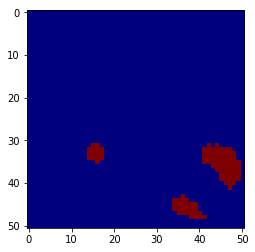

<Figure size 1080x1080 with 0 Axes>

In [6]:
#Creating mask

mask = np.load('1434mask_data.npy')
plt.imshow(mask, cmap = "jet") #jet, magma, inferno, copper
plt.figure(figsize=(15,15))
#mask = masked_simple_map_data > 0
#saving map data and mask

#plt.imsave(file_num +"map_q_{}-{}_chi_{}-{}-masked_jet.png".format(min_ROI_q, max_ROI_q, min_ROI_chi,\
 #                                                                  max_ROI_chi), masked_simple_map_data, cmap = "jet")
#np.save(file_num + "masked_map_data", masked_simple_map_data)
#np.save(file_num + "mask_data", mask)

In [7]:
#Getting a normalized masked  profile of ROI_q
scan_count = 0
masked_scan_sum = np.zeros((all_scans.shape[1],all_scans.shape[2]), dtype = np.float32)
start_time = time.time()
for i in range(map_width**2):
    x = int(i%map_width)
    y = int(i//map_width)
    if not mask[y,x]:
        masked_scan_sum+=all_scans[i]
        scan_count +=1
        
    print(i,"--- %s seconds ---" % (time.time() - start_time))
    
masked_scan_sum/=scan_count #normalizing

#saving
np.save(file_num + 'negative_masked_scan_sum', masked_scan_sum)

0 --- 0.1747300624847412 seconds ---
1 --- 0.3296341896057129 seconds ---
2 --- 0.5534982681274414 seconds ---
3 --- 0.7084002494812012 seconds ---
4 --- 0.7783567905426025 seconds ---
5 --- 0.8872902393341064 seconds ---
6 --- 0.9882278442382812 seconds ---
7 --- 1.0671813488006592 seconds ---
8 --- 1.1621215343475342 seconds ---
9 --- 1.2650573253631592 seconds ---
10 --- 1.3709921836853027 seconds ---
11 --- 1.4539437294006348 seconds ---
12 --- 1.5618748664855957 seconds ---
13 --- 1.672807216644287 seconds ---
14 --- 1.7497613430023193 seconds ---
15 --- 1.8886761665344238 seconds ---
16 --- 1.9636282920837402 seconds ---
17 --- 2.081555128097534 seconds ---
18 --- 2.1555099487304688 seconds ---
19 --- 2.26544189453125 seconds ---
20 --- 2.372375965118408 seconds ---
21 --- 2.484307050704956 seconds ---
22 --- 2.5912423133850098 seconds ---
23 --- 2.6831870079040527 seconds ---
24 --- 2.786121368408203 seconds ---
25 --- 2.9150421619415283 seconds ---
26 --- 2.98799729347229 secon

217 --- 22.84932518005371 seconds ---
218 --- 23.095463752746582 seconds ---
219 --- 23.10745644569397 seconds ---
220 --- 23.204396963119507 seconds ---
221 --- 23.284347772598267 seconds ---
222 --- 23.39228129386902 seconds ---
223 --- 23.506211280822754 seconds ---
224 --- 23.613147020339966 seconds ---
225 --- 23.68010401725769 seconds ---
226 --- 23.79503345489502 seconds ---
227 --- 23.90996265411377 seconds ---
228 --- 23.984917163848877 seconds ---
229 --- 24.077861070632935 seconds ---
230 --- 24.208778858184814 seconds ---
231 --- 24.305719137191772 seconds ---
232 --- 24.420648336410522 seconds ---
233 --- 24.51758885383606 seconds ---
234 --- 24.62552237510681 seconds ---
235 --- 24.72745966911316 seconds ---
236 --- 24.791420221328735 seconds ---
237 --- 24.881367206573486 seconds ---
238 --- 25.013288497924805 seconds ---
239 --- 25.104228019714355 seconds ---
240 --- 25.178182363510132 seconds ---
241 --- 25.291112899780273 seconds ---
242 --- 25.387053966522217 seconds

432 --- 45.63225197792053 seconds ---
433 --- 45.771167039871216 seconds ---
434 --- 45.85811448097229 seconds ---
435 --- 46.00402283668518 seconds ---
436 --- 46.10695958137512 seconds ---
437 --- 46.26985955238342 seconds ---
438 --- 46.33981680870056 seconds ---
439 --- 46.49572134017944 seconds ---
440 --- 46.59366059303284 seconds ---
441 --- 46.77754735946655 seconds ---
442 --- 46.84850311279297 seconds ---
443 --- 46.98142194747925 seconds ---
444 --- 47.06137537956238 seconds ---
445 --- 47.1763014793396 seconds ---
446 --- 47.2452597618103 seconds ---
447 --- 47.359190702438354 seconds ---
448 --- 47.48211336135864 seconds ---
449 --- 47.5360803604126 seconds ---
450 --- 47.65001034736633 seconds ---
451 --- 47.7569465637207 seconds ---
452 --- 47.86987495422363 seconds ---
453 --- 47.940831661224365 seconds ---
454 --- 48.057759284973145 seconds ---
455 --- 48.160696029663086 seconds ---
456 --- 48.27762532234192 seconds ---
457 --- 48.34658193588257 seconds ---
458 --- 48.

647 --- 68.1979386806488 seconds ---
648 --- 68.34185099601746 seconds ---
649 --- 68.40780782699585 seconds ---
650 --- 68.52773451805115 seconds ---
651 --- 68.59469437599182 seconds ---
652 --- 68.68463778495789 seconds ---
653 --- 68.80556297302246 seconds ---
654 --- 68.91749405860901 seconds ---
655 --- 68.98944997787476 seconds ---
656 --- 69.23650574684143 seconds ---
657 --- 69.24749994277954 seconds ---
658 --- 69.34543895721436 seconds ---
659 --- 69.47336030006409 seconds ---
660 --- 69.57329869270325 seconds ---
661 --- 69.73320293426514 seconds ---
662 --- 69.83313822746277 seconds ---
663 --- 69.97505259513855 seconds ---
664 --- 70.05899977684021 seconds ---
665 --- 70.20790910720825 seconds ---
666 --- 70.30784630775452 seconds ---
667 --- 70.50072741508484 seconds ---
668 --- 70.60066652297974 seconds ---
669 --- 70.79754543304443 seconds ---
670 --- 70.86150598526001 seconds ---
671 --- 71.04339385032654 seconds ---
672 --- 71.13333868980408 seconds ---
673 --- 71.31

864 --- 93.12099099159241 seconds ---
865 --- 93.31387186050415 seconds ---
866 --- 93.42180562019348 seconds ---
867 --- 93.62567973136902 seconds ---
868 --- 93.69263887405396 seconds ---
869 --- 93.88751912117004 seconds ---
870 --- 93.96946859359741 seconds ---
871 --- 94.14136719703674 seconds ---
872 --- 94.21631622314453 seconds ---
873 --- 94.36922359466553 seconds ---
874 --- 94.48515272140503 seconds ---
875 --- 94.64805054664612 seconds ---
876 --- 94.71500992774963 seconds ---
877 --- 94.86391925811768 seconds ---
878 --- 94.9808464050293 seconds ---
879 --- 95.14974451065063 seconds ---
880 --- 95.2236979007721 seconds ---
881 --- 95.3796010017395 seconds ---
882 --- 95.48953342437744 seconds ---
883 --- 95.71404218673706 seconds ---
884 --- 95.78000164031982 seconds ---
885 --- 95.93990302085876 seconds ---
886 --- 96.0398416519165 seconds ---
887 --- 96.15676975250244 seconds ---
888 --- 96.25371313095093 seconds ---
889 --- 96.45858407020569 seconds ---
890 --- 96.55752

1077 --- 118.32199597358704 seconds ---
1078 --- 118.42593121528625 seconds ---
1079 --- 118.57384085655212 seconds ---
1080 --- 118.67377853393555 seconds ---
1081 --- 118.80169987678528 seconds ---
1082 --- 118.90363717079163 seconds ---
1083 --- 119.09552049636841 seconds ---
1084 --- 119.29040050506592 seconds ---
1085 --- 119.63960242271423 seconds ---
1086 --- 119.6725800037384 seconds ---
1087 --- 119.85946273803711 seconds ---
1088 --- 120.02536082267761 seconds ---
1089 --- 120.09631896018982 seconds ---
1090 --- 120.24922299385071 seconds ---
1091 --- 120.36715197563171 seconds ---
1092 --- 120.50406622886658 seconds ---
1093 --- 120.70594191551208 seconds ---
1094 --- 120.79788541793823 seconds ---
1095 --- 120.95279002189636 seconds ---
1096 --- 121.12768244743347 seconds ---
1097 --- 121.2905821800232 seconds ---
1098 --- 121.39351916313171 seconds ---
1099 --- 121.54542541503906 seconds ---
1100 --- 121.64736413955688 seconds ---
1101 --- 121.77128672599792 seconds ---
11

1283 --- 144.87569451332092 seconds ---
1284 --- 145.01860690116882 seconds ---
1285 --- 145.12454175949097 seconds ---
1286 --- 145.24746751785278 seconds ---
1287 --- 145.35140442848206 seconds ---
1288 --- 145.4953134059906 seconds ---
1289 --- 145.6012487411499 seconds ---
1290 --- 145.71118092536926 seconds ---
1291 --- 145.82111382484436 seconds ---
1292 --- 145.96602368354797 seconds ---
1293 --- 146.0759563446045 seconds ---
1294 --- 146.18688797950745 seconds ---
1295 --- 146.29582118988037 seconds ---
1296 --- 146.4437301158905 seconds ---
1297 --- 146.55166387557983 seconds ---
1298 --- 146.67159152030945 seconds ---
1299 --- 146.78452062606812 seconds ---
1300 --- 146.93143010139465 seconds ---
1301 --- 147.03836464881897 seconds ---
1302 --- 147.16228795051575 seconds ---
1303 --- 147.2712209224701 seconds ---
1304 --- 147.43412065505981 seconds ---
1305 --- 147.53805685043335 seconds ---
1306 --- 147.8150236606598 seconds ---
1307 --- 147.8420045375824 seconds ---
1308 --

1490 --- 170.8679702281952 seconds ---
1491 --- 170.9819004535675 seconds ---
1492 --- 171.14380359649658 seconds ---
1493 --- 171.24873614311218 seconds ---
1494 --- 171.40464043617249 seconds ---
1495 --- 171.52356672286987 seconds ---
1496 --- 171.67547345161438 seconds ---
1497 --- 171.77941060066223 seconds ---
1498 --- 171.93231558799744 seconds ---
1499 --- 171.9992744922638 seconds ---
1500 --- 172.1531798839569 seconds ---
1501 --- 172.25611639022827 seconds ---
1502 --- 172.41701817512512 seconds ---
1503 --- 172.49696826934814 seconds ---
1504 --- 172.6428782939911 seconds ---
1505 --- 172.7418200969696 seconds ---
1506 --- 172.9057183265686 seconds ---
1507 --- 172.9706768989563 seconds ---
1508 --- 173.11958646774292 seconds ---
1509 --- 173.21952366828918 seconds ---
1510 --- 173.3794252872467 seconds ---
1511 --- 173.44538521766663 seconds ---
1512 --- 173.605286359787 seconds ---
1513 --- 173.705224275589 seconds ---
1514 --- 173.8541338443756 seconds ---
1515 --- 173.9

1702 --- 196.40656089782715 seconds ---
1703 --- 196.57645773887634 seconds ---
1704 --- 196.65141010284424 seconds ---
1705 --- 196.78532719612122 seconds ---
1706 --- 196.94123601913452 seconds ---
1707 --- 197.0851435661316 seconds ---
1708 --- 197.15709948539734 seconds ---
1709 --- 197.31000661849976 seconds ---
1710 --- 197.4609124660492 seconds ---
1711 --- 197.55785250663757 seconds ---
1712 --- 197.69876646995544 seconds ---
1713 --- 197.79170846939087 seconds ---
1714 --- 197.94661498069763 seconds ---
1715 --- 198.10851550102234 seconds ---
1716 --- 198.24343037605286 seconds ---
1717 --- 198.3303771018982 seconds ---
1718 --- 198.50826835632324 seconds ---
1719 --- 198.62519574165344 seconds ---
1720 --- 198.78709816932678 seconds ---
1721 --- 198.87304306030273 seconds ---
1722 --- 199.17803478240967 seconds ---
1723 --- 199.2729754447937 seconds ---
1724 --- 199.27397561073303 seconds ---
1725 --- 199.27497482299805 seconds ---
1726 --- 199.27497482299805 seconds ---
1727

1910 --- 220.0746021270752 seconds ---
1911 --- 220.18153619766235 seconds ---
1912 --- 220.31245827674866 seconds ---
1913 --- 220.42038917541504 seconds ---
1914 --- 220.48634958267212 seconds ---
1915 --- 220.60427618026733 seconds ---
1916 --- 220.7311975955963 seconds ---
1917 --- 220.84213495254517 seconds ---
1918 --- 220.9350745677948 seconds ---
1919 --- 221.0440056324005 seconds ---
1920 --- 221.17792320251465 seconds ---
1921 --- 221.24688124656677 seconds ---
1922 --- 221.38179731369019 seconds ---
1923 --- 221.4857361316681 seconds ---
1924 --- 221.61865162849426 seconds ---
1925 --- 221.68461227416992 seconds ---
1926 --- 221.87849259376526 seconds ---
1927 --- 221.98142838478088 seconds ---
1928 --- 222.09336113929749 seconds ---
1929 --- 222.16031885147095 seconds ---
1930 --- 222.27224969863892 seconds ---
1931 --- 222.27325010299683 seconds ---
1932 --- 222.2742486000061 seconds ---
1933 --- 222.2742486000061 seconds ---
1934 --- 222.2752480506897 seconds ---
1935 ---

2118 --- 242.1552004814148 seconds ---
2119 --- 242.26113772392273 seconds ---
2120 --- 242.36507391929626 seconds ---
2121 --- 242.4750039577484 seconds ---
2122 --- 242.5829393863678 seconds ---
2123 --- 242.64789748191833 seconds ---
2124 --- 242.73684430122375 seconds ---
2125 --- 242.8557698726654 seconds ---
2126 --- 242.9657018184662 seconds ---
2127 --- 243.03366041183472 seconds ---
2128 --- 243.19356274604797 seconds ---
2129 --- 243.29349946975708 seconds ---
2130 --- 243.4534032344818 seconds ---
2131 --- 243.51936173439026 seconds ---
2132 --- 243.65227913856506 seconds ---
2133 --- 243.77120804786682 seconds ---
2134 --- 243.9231128692627 seconds ---
2135 --- 244.00006580352783 seconds ---
2136 --- 244.1599669456482 seconds ---
2137 --- 244.27189779281616 seconds ---
2138 --- 244.27389764785767 seconds ---
2139 --- 244.55876684188843 seconds ---
2140 --- 244.70967268943787 seconds ---
2141 --- 244.88056802749634 seconds ---
2142 --- 244.9495267868042 seconds ---
2143 --- 

2326 --- 267.37797260284424 seconds ---
2327 --- 267.4849064350128 seconds ---
2328 --- 267.6258201599121 seconds ---
2329 --- 267.6268219947815 seconds ---
2330 --- 267.62782096862793 seconds ---
2331 --- 267.62881994247437 seconds ---
2332 --- 267.62982153892517 seconds ---
2333 --- 267.6308207511902 seconds ---
2334 --- 267.6318213939667 seconds ---
2335 --- 267.88616967201233 seconds ---
2336 --- 268.0830478668213 seconds ---
2337 --- 268.29678201675415 seconds ---
2338 --- 268.48066759109497 seconds ---
2339 --- 268.65955805778503 seconds ---
2340 --- 268.73051381111145 seconds ---
2341 --- 268.88242173194885 seconds ---
2342 --- 269.01334023475647 seconds ---
2343 --- 269.19722962379456 seconds ---
2344 --- 269.26518511772156 seconds ---
2345 --- 269.45007133483887 seconds ---
2346 --- 269.6059799194336 seconds ---
2347 --- 269.825865983963 seconds ---
2348 --- 269.8938241004944 seconds ---
2349 --- 270.0607204437256 seconds ---
2350 --- 270.23361468315125 seconds ---
2351 --- 27

2536 --- 293.21826553344727 seconds ---
2537 --- 293.2872221469879 seconds ---
2538 --- 293.4601163864136 seconds ---
2539 --- 293.56205344200134 seconds ---
2540 --- 293.7469391822815 seconds ---
2541 --- 293.81390500068665 seconds ---
2542 --- 294.05380177497864 seconds ---
2543 --- 294.1567347049713 seconds ---
2544 --- 294.3406219482422 seconds ---
2545 --- 294.40957975387573 seconds ---
2546 --- 294.60445976257324 seconds ---
2547 --- 294.70639657974243 seconds ---
2548 --- 294.90327548980713 seconds ---
2549 --- 294.9692349433899 seconds ---
2550 --- 295.15911841392517 seconds ---
2551 --- 295.27604603767395 seconds ---
2552 --- 295.46592903137207 seconds ---
2553 --- 295.5368854999542 seconds ---
2554 --- 295.7127773761749 seconds ---
2555 --- 295.8307046890259 seconds ---
2556 --- 296.09411549568176 seconds ---
2557 --- 296.1590733528137 seconds ---
2558 --- 296.34395837783813 seconds ---
2559 --- 296.4618864059448 seconds ---
2560 --- 296.65077018737793 seconds ---
2561 --- 29

In [33]:
for profile in masked_scan_sum:
    profile[profile < 0] = 0
 #   profile[profile > 1000] = 0

[[0.01915342 0.02215089 0.02087559 ... 0.         0.         0.        ]
 [0.01915342 0.02215089 0.02087559 ... 0.         0.         0.        ]
 [0.01915342 0.02215089 0.02087559 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
0.0 5.2991853


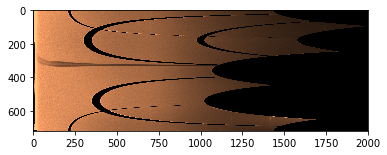

<Figure size 1008x1080 with 0 Axes>

In [40]:
plt.imshow(masked_scan_sum, cmap = "copper", clim = (0, 0.2)) #jet, magma, inferno, copper
plt.figure(figsize=(14,15))
print(masked_scan_sum)
print(np.amin(masked_scan_sum), np.amax(masked_scan_sum))

Profile width:  670
0.09445637 0.099007554


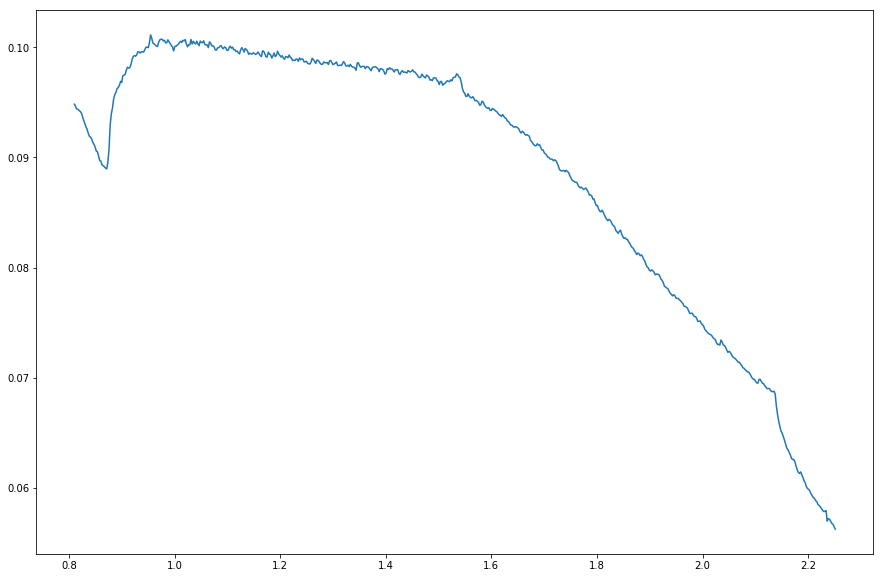

In [43]:
counter = 0 # profile counter
profile_sum = np.zeros(all_scans.shape[2], dtype=np.float32)
scan = masked_scan_sum
#scan = np.load('1434masked_scan_sum.npy')
#This cycle sums all profiles which have no negative values (-10) inside ROI
for j in range (min_ROI_chi,max_ROI_chi):
    if j not in range(310,360): #excluding beamstop
        profile = scan[j]
        if any(x<0 for x in profile[min_ROI_q:max_ROI_q]):
            continue
    
        profile_sum += profile
        counter +=1
                
profile_sum/=counter

#profile_sum[halo_min-1: halo_max] -= halo_baseline
plt.figure(figsize=(15,10))
plt.plot(q_set[min_ROI_q:max_ROI_q],profile_sum[min_ROI_q:max_ROI_q]) 
#plt.show()

print ("Profile width: ",counter)

print(np.amin(profile_sum[min_ROI_q:max_ROI_q]), np.amax(profile_sum[min_ROI_q:max_ROI_q]))


#np.save('1434profile', profile_sum)


In [ ]:
#Fitting peaks, getting initial guess parameters

x_array = q_set[min_ROI_q:max_ROI_q]
y_array = profile_sum[min_ROI_q:max_ROI_q]

#saving

np.savetxt('q_set.txt', x_array)
np.savetxt('profile.txt', y_array)

In [ ]:
x01 = 1.333
x02 = 1.510

def _2gaussian(x, y0, amp1,sigma1, amp2, sigma2):
    return y0 + amp1*np.exp(-((x-x01)**2)/(2*sigma1**2)) + amp2*np.exp(-((x-x02)**2)/(2*sigma2**2))





In [ ]:
popt_2gauss, pcov_2gauss = scipy.optimize.curve_fit(_2gaussian, x_array, y_array, p0 = [0.01, 0.2, 0.03, 0.04 , 0.05])   
    
perr_2gauss = np.sqrt(np.diag(pcov_2gauss))

pars_1 = popt_2gauss[1:3]
pars_2 = popt_2gauss[3:5]

In [ ]:
# this cell prints the fitting parameters with their errors
print ("-------------Peak 1-------------")
print ("amplitude = %0.2f (+/-) %0.2f" % (pars_1[0], perr_2gauss[1]))
print ("sigma = %0.2f (+/-) %0.2f" % (pars_1[1], perr_2gauss[2]))
#print ("area = %0.2f" % np.trapz(gauss_peak_1))
print ("--------------------------------")
print ("-------------Peak 2-------------")
print ("amplitude = %0.2f (+/-) %0.2f" % (pars_2[0], perr_2gauss[3]))
print ("sigma = %0.2f (+/-) %0.2f" % (pars_2[1], perr_2gauss[4]))
#print ("area = %0.2f" % np.trapz(gauss_peak_2))
print ("--------------------------------")

In [ ]:
fig = plt.figure(figsize=(4,3))
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0])

ax1.plot(x_array, y_array)
ax1.plot(x_array, _2gaussian(x_array, *popt_2gauss), 'k--')#,\
         #label="y= %0.2f$e^{%0.2fx}$ + %0.2f" % (popt_exponential[0], popt_exponential[1], popt_exponential[2]))
    

ax1.set_xlabel("x_array",family="serif",  fontsize=12)
ax1.set_ylabel("y_array",family="serif",  fontsize=12)

ax1.legend(loc="best")

ax1.xaxis.set_major_locator(ticker.MultipleLocator(20))
#ax1.yaxis.set_major_locator(ticker.MultipleLocator(50))

ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(AutoMinorLocator(2))

ax1.tick_params(axis='both',which='major', direction="out", top="on", right="on", bottom="on", length=8, labelsize=8)
ax1.tick_params(axis='both',which='minor', direction="out", top="on", right="on", bottom="on", length=5, labelsize=8)

fig.tight_layout()
fig.savefig("fit2Gaussian.png", format="png",dpi=1000)

In [ ]:
#Mapping with gauss fit

params = np.load('params_gaussian_left_1434.npy')


start_time = time.time() #time counter
map_data = np.zeros((map_width,map_width), dtype=np.float32) 

for i in range(map_width**2):
        current_scan = all_scans[i]   
        profile_sum = np.zeros(all_scans.shape[2], dtype=np.float32)
        
        for j in range (min_ROI_chi,max_ROI_chi):
            profile = current_scan[j]           
            if (-10 not in profile[min_ROI_q:max_ROI_q]):
                profile_sum += profile

        x_array= q_set[min_ROI_q:max_ROI_q]
        y_array = profile_sum[min_ROI_q:max_ROI_q]-halo_baseline[min_ROI_q:max_ROI_q]
        
        
        popt_2gauss, pcov_2gauss = scipy.optimize.curve_fit(_2gaussian, x_array, y_array, p0 = [0.01, 0.2, 0.03, 0.04, 0.05])   
    
        perr_2gauss = np.sqrt(np.diag(pcov_2gauss))

        
        #gaussian(x, y0, amp1,cen1,sigma1, amp2,cen2,sigma2)
        I = popt_2gauss[1]/(popt_2gauss[2]*np.sqrt(2*np.pi)) + popt_2gauss[3]/(popt_2gauss[4]*np.sqrt(2*np.pi))
        x = int(i%map_width)
        y = int(i//map_width)
        
        map_data[y, x]=I
        print(i,"--- %s seconds ---" % (time.time() - start_time))

In [ ]:
plt.imshow(map_data, cmap = "magma")
plt.figure(figsize=(15,15))

In [ ]:
test_data = map_data.flatten()
plt.hist(test_data, bins = 300)
plt.show()

In [ ]:
#amp1 = 100
#sigma1 = 10
#cen1 = 40

#amp2 = 75
#sigma2 = 5
#cen2 = 65

#x_array = np.linspace(1,100,50)

#y_array_2gauss = amp1*np.exp(-((x_array-cen1)**2)/(2*sigma1**2))+ \
 #               amp2*np.exp(-((x_array-cen2)**2)/(2*sigma2**2))
    
x_array = q_set[min_ROI_q:max_ROI_q]
y_array_2gauss = profile_sum[min_ROI_q:max_ROI_q]


In [ ]:
fig = plt.figure(figsize=(4,3))
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0])

ax1.plot(x_array, y_array_2gauss)


ax1.set_xlabel("x_array",family="serif",  fontsize=12)
ax1.set_ylabel("y_array",family="serif",  fontsize=12)

ax1.xaxis.set_major_locator(ticker.MultipleLocator(20))
#ax1.yaxis.set_major_locator(ticker.MultipleLocator(50))

ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(AutoMinorLocator(2))

ax1.tick_params(axis='both',which='major', direction="out", top="on", right="on", bottom="on", length=8, labelsize=8)
ax1.tick_params(axis='both',which='minor', direction="out", top="on", right="on", bottom="on", length=5, labelsize=8)

fig.tight_layout()
fig.savefig("raw2Gaussian.png", format="png",dpi=1000)

In [ ]:
def _1gaussian(x, amp1,cen1,sigma1):
    return amp1*np.exp(-((x-cen1)**2)/(2*sigma1**2))

In [ ]:
def _2gaussian(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*np.exp(-((x-cen1)**2)/(2*sigma1**2)) +\
           amp2*np.exp(-((x-cen2)**2)/(2*sigma2**2))

In [ ]:
#popt_2gauss, pcov_2gauss = scipy.optimize.curve_fit(_2gaussian, x_array, y_array_2gauss, p0=[amp1, cen1, sigma1, \
    #                                                                                      amp2, cen2, sigma2])

popt_2gauss, pcov_2gauss = scipy.optimize.curve_fit(_2gaussian, x_array, y_array_2gauss)   
    
perr_2gauss = np.sqrt(np.diag(pcov_2gauss))

pars_1 = popt_2gauss[0:3]
pars_2 = popt_2gauss[3:6]
gauss_peak_1 = _1gaussian(x_array, *pars_1)
gauss_peak_2 = _1gaussian(x_array, *pars_2)

In [ ]:
# this cell prints the fitting parameters with their errors
print ("-------------Peak 1-------------")
print ("amplitude = %0.2f (+/-) %0.2f" % (pars_1[0], perr_2gauss[0]))
print ("center = %0.2f (+/-) %0.2f" % (pars_1[1], perr_2gauss[1]))
print ("sigma = %0.2f (+/-) %0.2f" % (pars_1[2], perr_2gauss[2]))
print ("area = %0.2f" % np.trapz(gauss_peak_1))
print ("--------------------------------")
print ("-------------Peak 2-------------")
print ("amplitude = %0.2f (+/-) %0.2f" % (pars_2[0], perr_2gauss[3]))
print ("center = %0.2f (+/-) %0.2f" % (pars_2[1], perr_2gauss[4]))
print ("sigma = %0.2f (+/-) %0.2f" % (pars_2[2], perr_2gauss[5]))
print ("area = %0.2f" % np.trapz(gauss_peak_2))
print ("--------------------------------")

In [ ]:
fig = plt.figure(figsize=(4,3))
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0])

ax1.plot(x_array, y_array_2gauss)
ax1.plot(x_array, _2gaussian(x_array, *popt_2gauss), 'k--')#,\
         #label="y= %0.2f$e^{%0.2fx}$ + %0.2f" % (popt_exponential[0], popt_exponential[1], popt_exponential[2]))
    

ax1.set_xlabel("x_array",family="serif",  fontsize=12)
ax1.set_ylabel("y_array",family="serif",  fontsize=12)

ax1.legend(loc="best")

ax1.xaxis.set_major_locator(ticker.MultipleLocator(20))
#ax1.yaxis.set_major_locator(ticker.MultipleLocator(50))

ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(AutoMinorLocator(2))

ax1.tick_params(axis='both',which='major', direction="out", top="on", right="on", bottom="on", length=8, labelsize=8)
ax1.tick_params(axis='both',which='minor', direction="out", top="on", right="on", bottom="on", length=5, labelsize=8)

fig.tight_layout()
#fig.savefig("fit2Gaussian.png", format="png",dpi=1000)

In [ ]:
fig = plt.figure(figsize=(4,3))
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0])

ax1.plot(x_array, y_array_2gauss, "ro")
ax1.plot(x_array, _2gaussian(x_array, *popt_2gauss), 'k--')#,\
         #label="y= %0.2f$e^{%0.2fx}$ + %0.2f" % (popt_exponential[0], popt_exponential[1], popt_exponential[2]))

# peak 1
ax1.plot(x_array, gauss_peak_1, "g")
ax1.fill_between(x_array, gauss_peak_1.min(), gauss_peak_1, facecolor="green", alpha=0.5)
  
# peak 2
ax1.plot(x_array, gauss_peak_2, "y")
ax1.fill_between(x_array, gauss_peak_2.min(), gauss_peak_2, facecolor="yellow", alpha=0.5)  

ax1.set_xlabel("x_array",family="serif",  fontsize=12)
ax1.set_ylabel("y_array",family="serif",  fontsize=12)

ax1.legend(loc="best")

ax1.xaxis.set_major_locator(ticker.MultipleLocator(20))
#ax1.yaxis.set_major_locator(ticker.MultipleLocator(50))

ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(AutoMinorLocator(2))

ax1.tick_params(axis='both',which='major', direction="out", top="on", right="on", bottom="on", length=8, labelsize=8)
ax1.tick_params(axis='both',which='minor', direction="out", top="on", right="on", bottom="on", length=5, labelsize=8)

fig.tight_layout()
fig.savefig("fit2Gaussian_peaks.png", format="png",dpi=1000)

In [ ]:
plt.close()

In [ ]:
plt.savefig('scansum_profile_1434_left_peak_without mask.png')

In [ ]:
#Trying to fit with Guassian

x = q_set[min_ROI_q:max_ROI_q]
y = profile_sum[min_ROI_q:max_ROI_q]


def gaussian(x, mu, sig, A, y0):
    return y0 + A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

popt, pcov = scipy.optimize.curve_fit(gaussian, x, y)
print(popt)

In [ ]:
np.save('params_gaussian_right_1434', popt)

In [ ]:


plt.figure(figsize=(10,6))
plt.plot(q_set[min_ROI_q:max_ROI_q], profile_sum[min_ROI_q:max_ROI_q], label = "original profile - 1434 masked normalized")
plt.plot(q_set[min_ROI_q:max_ROI_q], gaussian(q_set[min_ROI_q:max_ROI_q], *popt), label=' gaussian fit')
plt.legend()

In [ ]:
file.close()